### **Import Libraries**

In [87]:
# Data Processing Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import tensorflow as tf

# Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Model Libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE


In [88]:
warnings.filterwarnings('ignore')

### **Load and Explore Dataset**

In [89]:
# Load CSV
df = pd.read_csv('/content/iris.csv')

# Quick look at the data
print(df.head())
print("\n", df["class"].value_counts())
print("\n")
print(df.info())

   sepal_length  sepal_width  petal_length  petal_width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

 class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


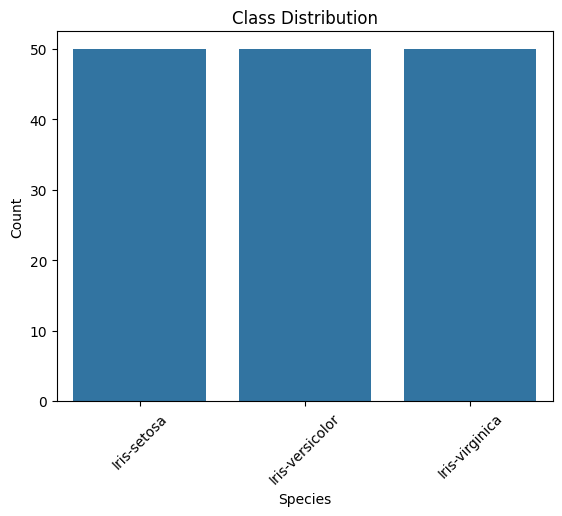

In [90]:
# Target class distribution plot

sns.countplot(data=df, x='class')
plt.title("Class Distribution")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

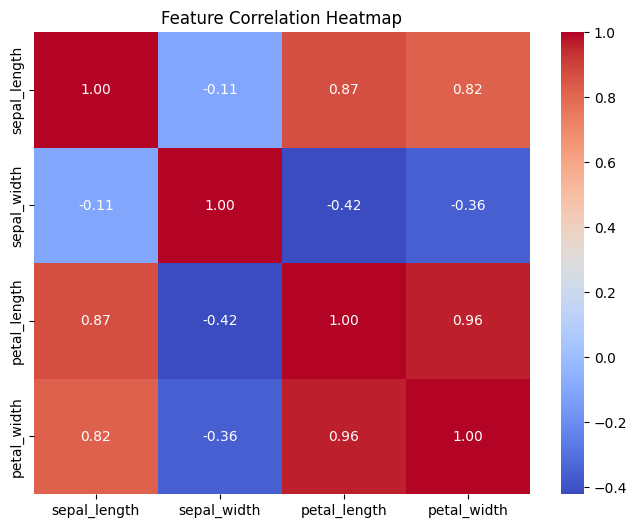

In [91]:
# Heatmap plot
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop('class', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

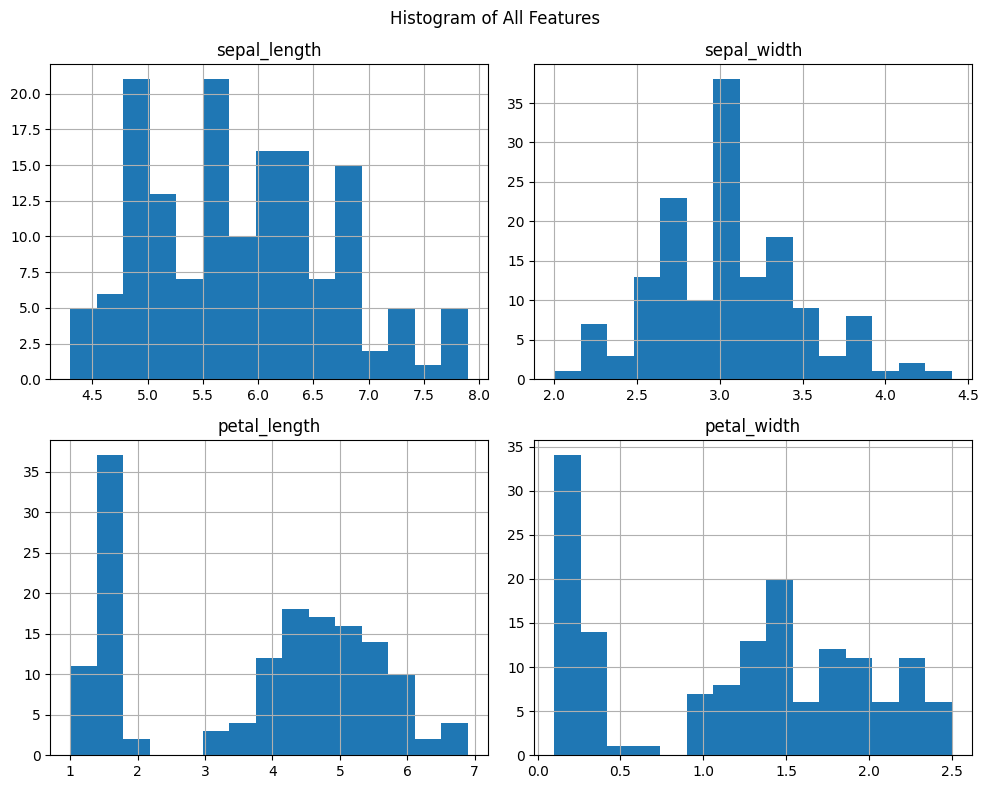

In [92]:
# Histogram of all features
df.hist(figsize=(10, 8), bins=15)
plt.suptitle("Histogram of All Features")
plt.tight_layout()
plt.show()


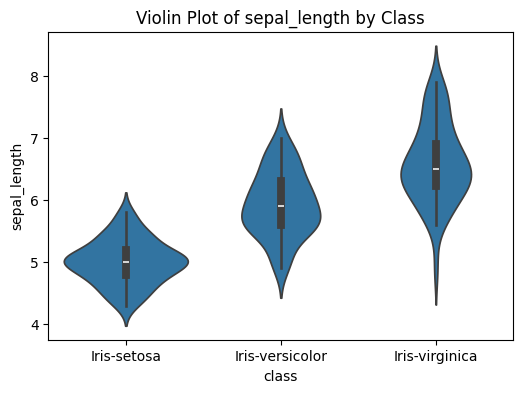

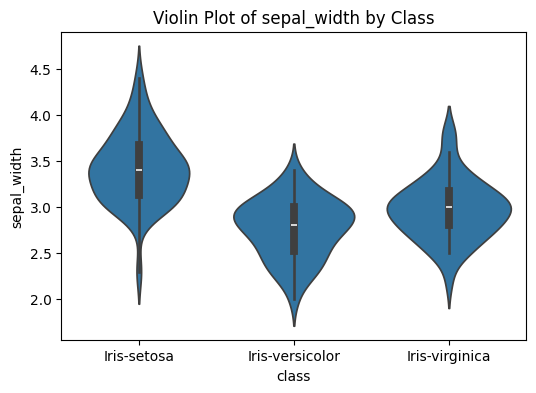

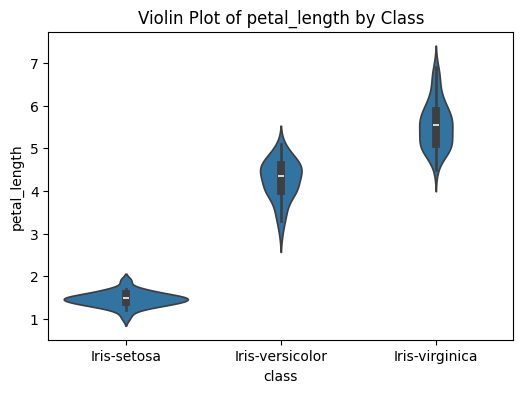

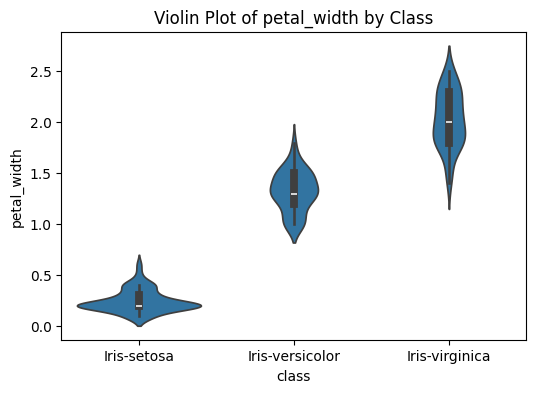

In [93]:
# Violin plot by class
for col in df.columns[:-1]:
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='class', y=col, data=df)
    plt.title(f'Violin Plot of {col} by Class')
    plt.show()


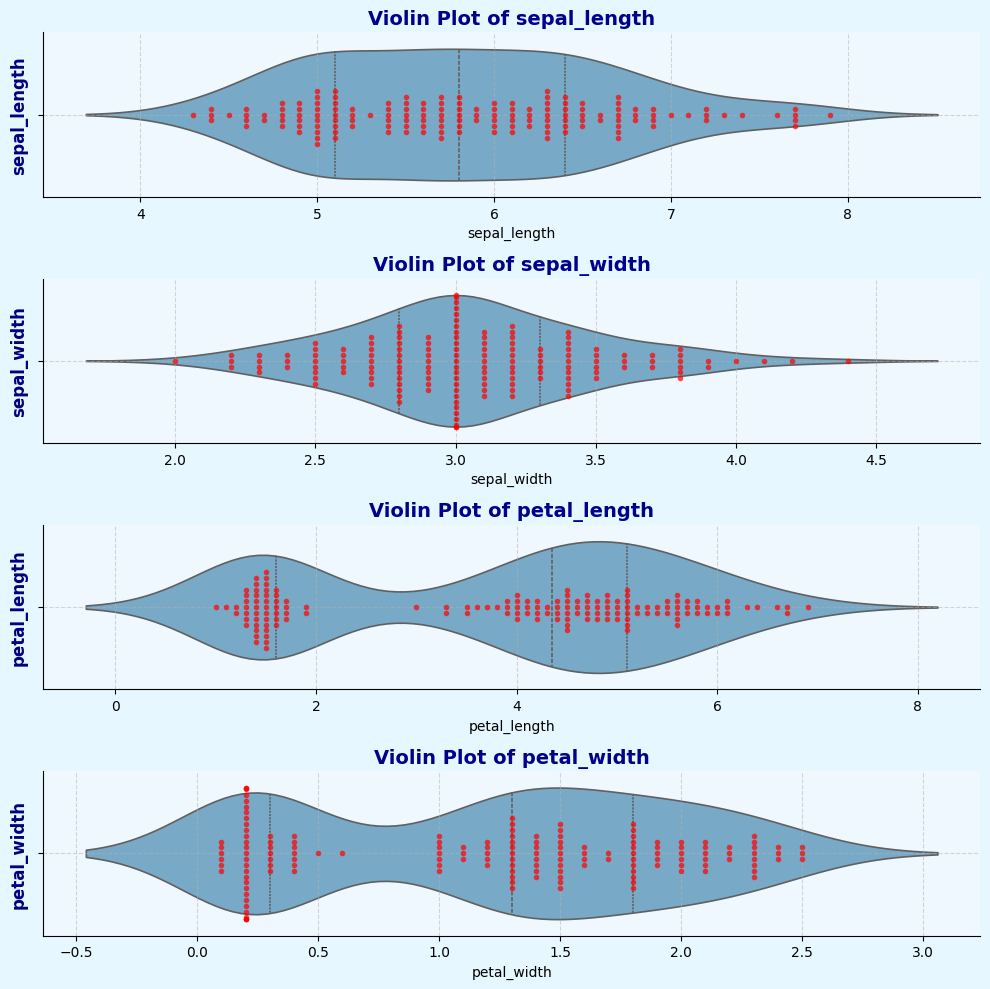

In [94]:
# Viloin plot for outliers detection

num_of_cols_without_target = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Set figure size dynamically
fig, axes = plt.subplots(nrows=len(num_of_cols_without_target), ncols=1, figsize=(10, len(num_of_cols_without_target) * 2.5), sharex=False)

# Set overall background color
fig.patch.set_facecolor('#E6F7FF')  # Light blue background

# Ensure axes is always iterable
if len(num_of_cols_without_target) == 1:
    axes = [axes]

# Loop through each feature and create a violin plot with swarmplot
for i, feature in enumerate(num_of_cols_without_target):
    sns.violinplot(x=df[feature], ax=axes[i], inner="quartile", palette="Blues", linewidth=1.2)

    # Overlay swarmplot to highlight individual points, especially outliers
    sns.swarmplot(x=df[feature], ax=axes[i], color="red", alpha=0.7, size=4)

    axes[i].set_ylabel(feature, fontsize=12, fontweight='bold', color='navy')
    axes[i].grid(True, linestyle="--", alpha=0.5)
    axes[i].set_facecolor("#F0F8FF")  # Light pastel background for subplots
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    # Add title
    axes[i].set_title(f'Violin Plot of {feature}', fontsize=14, fontweight="bold", color="darkblue")

# Adjust spacing
plt.tight_layout()
plt.show()

### **Preprocess the Data**

Dealing with Outliers

In [95]:
# Outlier detection and replacement using IQR
for col in ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median
    median_value = df[col].median()
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median_value, df[col])


**Preprocessing**

In [96]:
# Encode string class labels into integers
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(df["class"])

# One-hot encode the integer labels
y_encoded = to_categorical(y_int)

# Extract features
X = df.drop("class", axis=1).values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [97]:
# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Second split: Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Confirm shapes
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Training set: (105, 4)
Validation set: (22, 4)
Test set: (23, 4)


### **Feed-Forward Neural Network**

In [134]:

# Define FFNN model with more aggressive dropout
model_ffnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_ffnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model (on original data now — not noisy)
history_ffnn = model_ffnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=55,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2723 - loss: 1.1396 - val_accuracy: 0.4545 - val_loss: 1.0623
Epoch 2/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4104 - loss: 1.0757 - val_accuracy: 0.8182 - val_loss: 0.9706
Epoch 3/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4964 - loss: 0.9900 - val_accuracy: 0.8182 - val_loss: 0.8852
Epoch 4/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6521 - loss: 0.9059 - val_accuracy: 0.8182 - val_loss: 0.7798
Epoch 5/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7549 - loss: 0.8168 - val_accuracy: 0.8182 - val_loss: 0.6810
Epoch 6/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7112 - loss: 0.7375 - val_accuracy: 0.8182 - val_loss: 0.5984
Epoch 7/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7446 - loss: 0.6989 - val_accuracy: 0.8182 - val_loss: 0.5318
Epoch 8/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8410 - loss: 0.5764 - val_accuracy: 0.8182 - val_lo

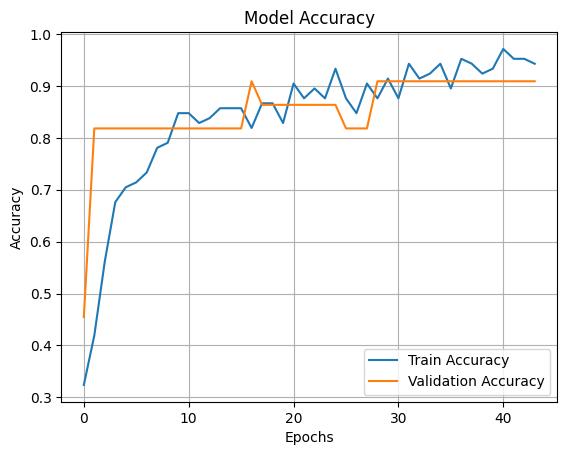

In [138]:
# Plot training vs validation accuracy
plt.plot(history_ffnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_ffnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

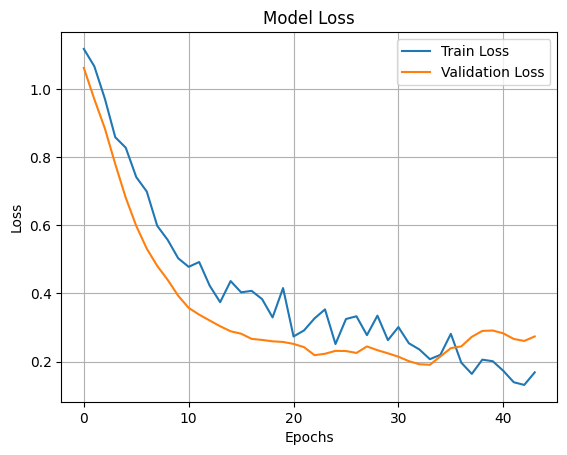

In [142]:
# Plot training vs validation loss
plt.plot(history_ffnn.history['loss'], label='Train Loss')
plt.plot(history_ffnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       1.00      0.75      0.86         8
 Iris-virginica       0.78      1.00      0.88         7

       accuracy                           0.91        23
      macro avg       0.93      0.92      0.91        23
   weighted avg       0.93      0.91      0.91        23



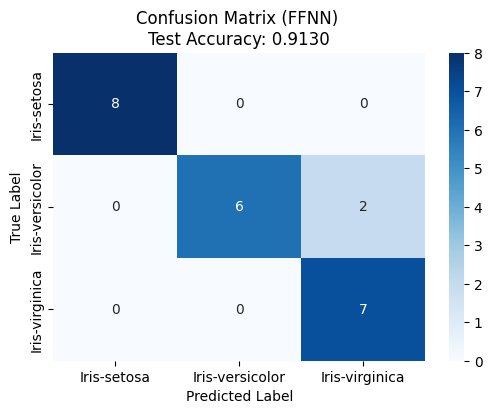

In [137]:
# Predict test set
y_pred_probs = model_ffnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
test_accuracy = accuracy_score(y_true, y_pred)

# Classification report (Precision, Recall, F1-score)
target_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f"Confusion Matrix (FFNN) \nTest Accuracy: {test_accuracy:.4f}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### **Autoencoder-based Dimensionality Reduction + Feedforward Neural Network Classifier**

In [117]:
# To store results
results = []

# Try 10 seeds
seed_range = range(10, 20)

for seed in seed_range:
    print(f"\nRunning for seed: {seed}")

    # Set seeds for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Autoencoder
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense

    input_dim = X_train.shape[1]
    encoding_dim = 2

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(3, activation='relu')(input_layer)
    bottleneck = Dense(encoding_dim, activation='relu')(encoded)
    decoded = Dense(3, activation='relu')(bottleneck)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=90,
        batch_size=8,
        verbose=0
    )

    # Encoder model
    encoder = Model(inputs=input_layer, outputs=bottleneck)
    X_train_encoded = encoder.predict(X_train)
    X_val_encoded = encoder.predict(X_val)
    X_test_encoded = encoder.predict(X_test)

    # Classifier on Encoded Features
    classifier = Sequential([
        Dense(64, activation='relu', input_shape=(encoding_dim,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(4, activation='relu'),
        Dense(3, activation='softmax')
    ])

    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    classifier.fit(
        X_train_encoded, y_train,
        validation_data=(X_val_encoded, y_val),
        epochs=60,
        batch_size=8,
        verbose=0
    )

    # Evaluation
    y_pred_probs = classifier.predict(X_test_encoded)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred)
    print(f"Seed {seed} - Test Accuracy: {acc:.4f}")

    results.append((seed, acc))



Running for seed: 10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Seed 10 - Test Accuracy: 0.8696

Running for seed: 11
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Seed 11 - Test Accuracy: 0.9130

Running for seed: 12
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Seed 12 - Test Accuracy: 0.8261

Running for seed: 13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Seed 13 - Test Accuracy: 0.9130

Running for seed: 14
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Se

In [124]:
# Sort by best accuracy
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

print("\nTop Seeds by Accuracy:")
for seed, acc in results_sorted:
    print(f"Seed: {seed} | Accuracy: {acc:.4f}")



Top Seeds by Accuracy:
Seed: 11 | Accuracy: 0.9130
Seed: 13 | Accuracy: 0.9130
Seed: 19 | Accuracy: 0.9130
Seed: 10 | Accuracy: 0.8696
Seed: 17 | Accuracy: 0.8696
Seed: 12 | Accuracy: 0.8261
Seed: 16 | Accuracy: 0.8261
Seed: 14 | Accuracy: 0.7391
Seed: 18 | Accuracy: 0.7391
Seed: 15 | Accuracy: 0.6522


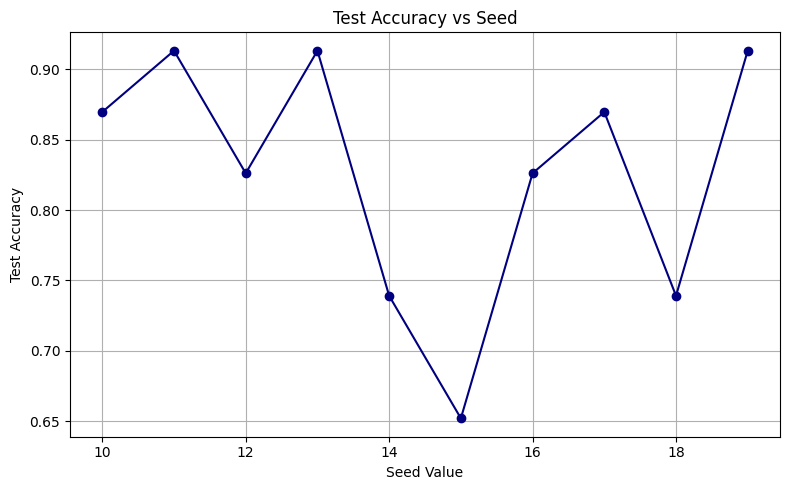

In [125]:
# Extract seeds and accuracies
seeds = [item[0] for item in results]
accuracies = [item[1] for item in results]

plt.figure(figsize=(8, 5))
plt.plot(seeds, accuracies, marker='o', linestyle='-', color='navy')
plt.title("Test Accuracy vs Seed")
plt.xlabel("Seed Value")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [126]:
# Get best seed
best_seed, best_acc = max(results, key=lambda x: x[1])
print(f"\nBest seed found: {best_seed} with accuracy: {best_acc:.4f}")

# Set the best seed again
os.environ['PYTHONHASHSEED'] = str(best_seed)
random.seed(best_seed)
np.random.seed(best_seed)
tf.random.set_seed(best_seed)

# Retrain Autoencoder on best seed
input_layer = Input(shape=(input_dim,))
encoded = Dense(3, activation='relu')(input_layer)
bottleneck = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(3, activation='relu')(bottleneck)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=90,
    batch_size=8,
    verbose=0
)

encoder = Model(inputs=input_layer, outputs=bottleneck)
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)

# Retrain Classifier
classifier = Sequential([
    Dense(64, activation='relu', input_shape=(encoding_dim,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(3, activation='softmax')
])

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = classifier.fit(
    X_train_encoded, y_train,
    validation_data=(X_val_encoded, y_val),
    epochs=55,
    batch_size=8,
    verbose=1
)

# Final Test Evaluation
y_pred_probs = classifier.predict(X_test_encoded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

final_acc = accuracy_score(y_true, y_pred)
print(f"\nFinal Model Accuracy with Best Seed ({best_seed}): {final_acc:.4f}")



Best seed found: 11 with accuracy: 0.9130
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 1/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5968 - loss: 1.0871 - val_accuracy: 0.4091 - val_loss: 1.0826
Epoch 2/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5281 - loss: 1.0642 - val_accuracy: 0.6364 - val_loss: 1.0688
Epoch 3/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7624 - loss: 1.0343 - val_accuracy: 0.6818 - val_loss: 1.0489
Epoch 4/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7111 - loss: 1.0008 - val_accuracy: 0.5455 - val_loss: 1.0378
Epoch 5/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6421 - loss: 0.9636 - val_accuracy: 0.5455 - val_loss: 1.0431
Epoch 6/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6421 - loss: 0.9448 - val_accuracy: 0.5455 - val_loss: 1.0559
Epoch 7/55
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6421 - loss: 0.9337 

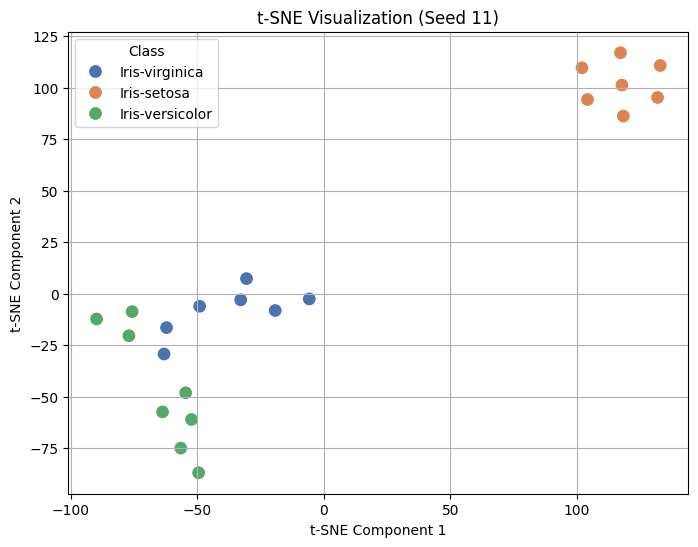

In [127]:
# t-SNE Visualisation of Encoded Test Features
tsne = TSNE(n_components=2, perplexity=5, random_state=best_seed)
X_test_tsne = tsne.fit_transform(X_test_encoded)

# Convert y_true to class labels (not one-hot encoding)
y_labels = label_encoder.inverse_transform(y_true)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_labels, palette='deep', s=100)
plt.title(f"t-SNE Visualization (Seed {best_seed})")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Class')
plt.grid(True)
plt.show()


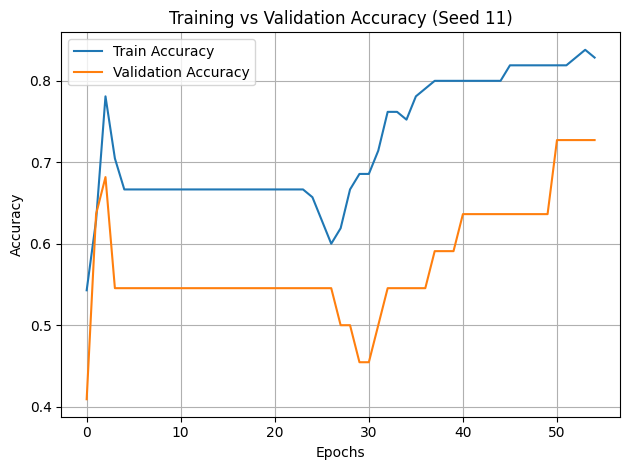

In [128]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Training vs Validation Accuracy (Seed {best_seed})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

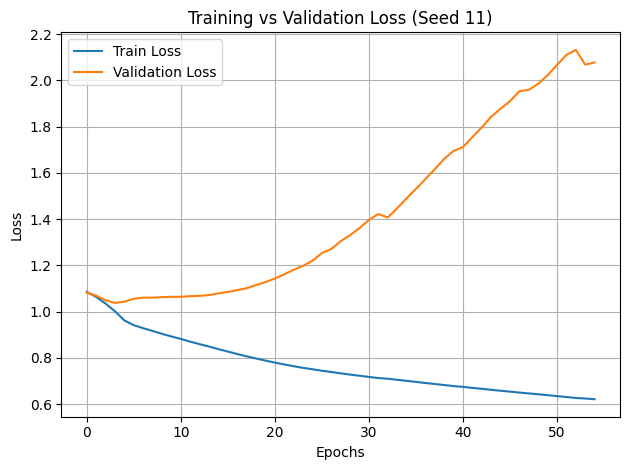

In [141]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Training vs Validation Loss (Seed {best_seed})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

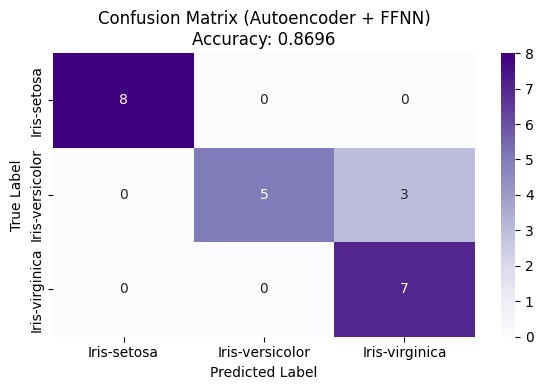

In [129]:
# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title(f"Confusion Matrix (Autoencoder + FFNN)\nAccuracy: {final_acc:.4f}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
